# Impact of Academic Factors on Final Grades

The test below looks into.......

## Features Related to Academic Factors

### Independent Variables: 
**school** - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira) <br>
**studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) <br>
**failures** - number of past class failures (numeric: n if 1<=n<3, else 4) <br>
**schoolsup** - extra educational support (binary: yes or no) <br>
**famsup** - family educational support (binary: yes or no) <br>
**paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) <br>
**higher** - wants to take higher education (binary: yes or no)<br>
**absences** - number of school absences (numeric: from 0 to 93)

### Dpendent Variables: 
**G1** - first period grade (numeric: from 0 to 20) <br>
**G2** - second period grade (numeric: from 0 to 20) <br>
**G3** - final grade (numeric: from 0 to 20, output target) <br>

In [1]:
# Import libraries
import pandas as pd
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Read in the datasets
students_mat = pd.read_csv('../dataset/student-mat.csv', delimiter=';')
students_por = pd.read_csv('../dataset/student-por.csv', delimiter=';')

# Merge common students
mat_students_merged = students_mat.merge(students_por[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])
por_students_merged = students_por.merge(students_mat[["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]])

# Filter out for academic features
mat_students = mat_students_merged[['school', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'absences', 'G1', 'G2', 'G3']]
por_students = por_students_merged[['school', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'absences', 'G1', 'G2', 'G3']]

In [3]:
mat_students.head(3) # View the math dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,absences,G1,G2,G3
0,GP,2,0,yes,no,no,yes,6,5,6,6
1,GP,2,0,no,yes,no,yes,4,5,5,6
2,GP,2,3,yes,no,yes,yes,10,7,8,10


In [4]:
por_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,absences,G1,G2,G3
0,GP,2,0,yes,no,no,yes,4,0,11,11
1,GP,2,0,no,yes,no,yes,2,9,11,11
2,GP,2,0,yes,no,no,yes,6,12,13,12


In [5]:
# Create a dictionary mapping 'yes' to 1 and 'no' to 0
mapping = {'yes': 1, 'no': 0, 'GP': 1, 'MS': 0}

mat_students['school'] = mat_students['school'].replace(mapping)
por_students['school'] = por_students['school'].replace(mapping)

mat_students['schoolsup'] = mat_students['schoolsup'].replace(mapping)
mat_students['famsup'] = mat_students['famsup'].replace(mapping)
mat_students['paid'] = mat_students['paid'].replace(mapping)
mat_students['higher'] = mat_students['higher'].replace(mapping)
por_students['schoolsup'] = por_students['schoolsup'].replace(mapping)
por_students['famsup'] = por_students['famsup'].replace(mapping)
por_students['paid'] = por_students['paid'].replace(mapping)
por_students['higher'] = por_students['higher'].replace(mapping)

C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zuzal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [6]:
mat_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,absences,G1,G2,G3
0,1,2,0,1,0,0,1,6,5,6,6
1,1,2,0,0,1,0,1,4,5,5,6
2,1,2,3,1,0,1,1,10,7,8,10


In [7]:
por_students.head(3) # View the por dataset

,school,studytime,failures,schoolsup,famsup,paid,higher,absences,G1,G2,G3
0,1,2,0,1,0,0,1,4,0,11,11
1,1,2,0,0,1,0,1,2,9,11,11
2,1,2,0,1,0,0,1,6,12,13,12


In [8]:
mat_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for mat class

,count,mean,std,min,25%,50%,75%,max
school,382.00,0.90,0.31,0.00,1.00,1.00,1.00,1.00
studytime,382.00,2.03,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.29,0.73,0.00,0.00,0.00,0.00,3.00
schoolsup,382.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
famsup,382.00,0.62,0.49,0.00,0.00,1.00,1.00,1.00
paid,382.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
higher,382.00,0.95,0.21,0.00,1.00,1.00,1.00,1.00
absences,382.00,5.32,7.63,0.00,0.00,3.00,8.00,75.00
G1,382.00,10.86,3.35,3.00,8.00,10.50,13.00,19.00
G2,382.00,10.71,3.83,0.00,8.25,11.00,13.00,19.00


In [9]:
por_students.describe().applymap('{:,.2f}'.format).T # descriptive statistics for por class

,count,mean,std,min,25%,50%,75%,max
school,382.00,0.90,0.31,0.00,1.00,1.00,1.00,1.00
studytime,382.00,2.04,0.85,1.00,1.00,2.00,2.00,4.00
failures,382.00,0.14,0.51,0.00,0.00,0.00,0.00,3.00
schoolsup,382.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
famsup,382.00,0.63,0.48,0.00,0.00,1.00,1.00,1.00
paid,382.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00
higher,382.00,0.95,0.21,0.00,1.00,1.00,1.00,1.00
absences,382.00,3.67,4.91,0.00,0.00,2.00,6.00,32.00
G1,382.00,12.11,2.56,0.00,10.00,12.00,14.00,19.00
G2,382.00,12.24,2.47,5.00,11.00,12.00,14.00,19.00


In [10]:
columns = ['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'absences']  # independent variables
n_plots = len(columns) 

# Plot frequency distributions for each independent variable
def plot_variables(table):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(12,8))
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        table[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
        ax.set_xlabel(columns[i])
        ax.set_ylabel('Count')
        ax.set_title('Histogram for variable: ' + columns[i])
    fig.tight_layout()
    plt.show()

MAT STUDENTS


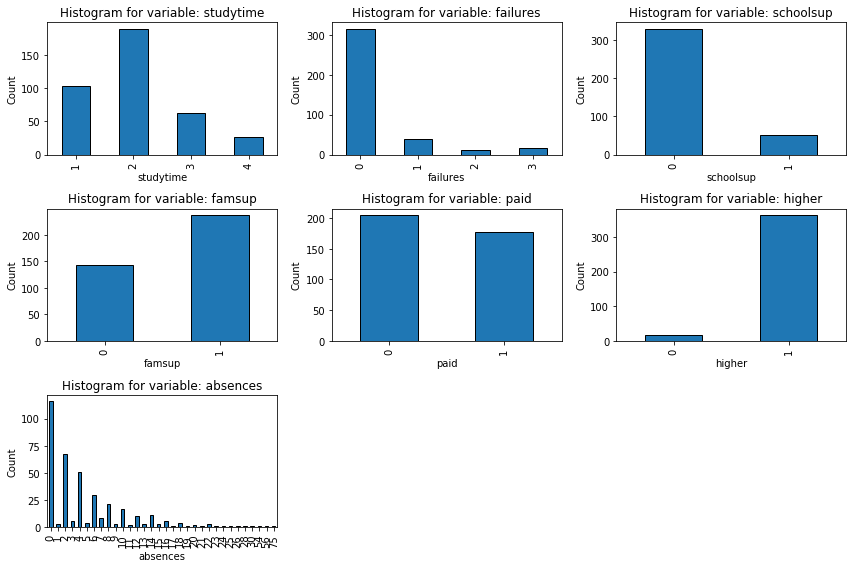

POR STUDENTS


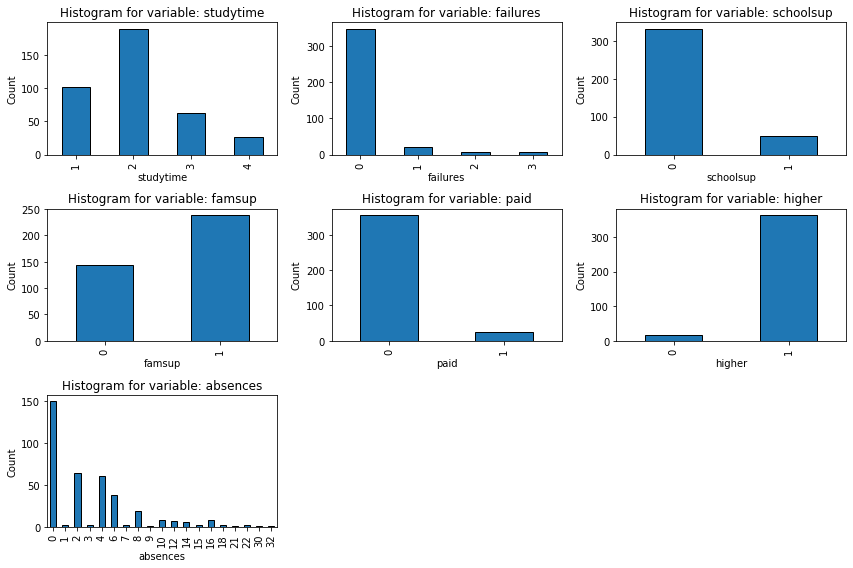

In [11]:
print('MAT STUDENTS')
plot_variables(mat_students)
print('POR STUDENTS')
plot_variables(por_students)

In [12]:
studytime = [1, 2, 3, 4]

# Grouped bar chart of mean grades per study time group
def grouped_bar(table):
    width = 0.2
    for x in studytime:
        y1 = table.loc[table['studytime'] == x]['G1'].mean()
        y2 = table.loc[table['studytime'] == x]['G2'].mean()
        y3 = table.loc[table['studytime'] == x]['G3'].mean()
        plt.bar(x-width, y1, width, color='blue', edgecolor='black') 
        plt.bar(x, y2, width, color='orange', edgecolor='black') 
        plt.bar(x+width, y3, width, color='green', edgecolor='black') 

    plt.xticks(studytime) 
    plt.xlabel("Study Time") 
    plt.ylabel("Mean Grade")
    plt.title("Mean Grades by Study Time")
    plt.legend(["G1", "G2", "G3"], loc='lower center') 
    plt.show() 

MAT STUDENTS


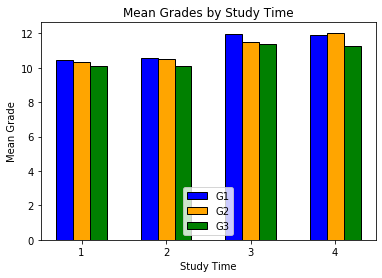

POR STUDENTS


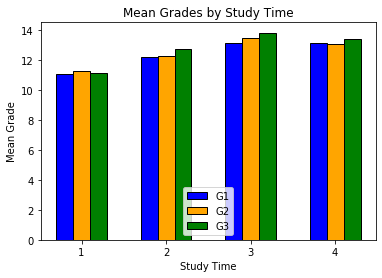

In [13]:
print("MAT STUDENTS")
grouped_bar(mat_students)
print("POR STUDENTS")
grouped_bar(por_students)

Interpret results...

## Significance Testing Using Chi-Squared Test
Since the variables we are dealing with are categorical.

In [14]:
columns.append('school') # include school in correlation matrix

In [15]:
# check if variables are correlated with each other
mat_students[columns].corr() # correlation matrix for independent variables

,studytime,failures,schoolsup,famsup,paid,higher,absences,school
studytime,1.000000,-0.198990,0.029744,0.159236,0.161443,0.184467,-0.073315,0.084631
failures,-0.198990,1.000000,0.023038,-0.023408,-0.197673,-0.369164,0.017246,-0.004424
schoolsup,0.029744,0.023038,1.000000,0.082983,-0.025172,0.014643,0.025987,0.134242
famsup,0.159236,-0.023408,0.082983,1.000000,0.267807,0.081949,0.002121,0.157394
paid,0.161443,-0.197673,-0.025172,0.267807,1.000000,0.181856,0.024453,0.009156
higher,0.184467,-0.369164,0.014643,0.081949,0.181856,1.000000,-0.031231,0.004648
absences,-0.073315,0.017246,0.025987,0.002121,0.024453,-0.031231,1.000000,0.077215
school,0.084631,-0.004424,0.134242,0.157394,0.009156,0.004648,0.077215,1.000000


In [16]:
por_students[columns].corr() # correlation matrix for independent variables

,studytime,failures,schoolsup,famsup,paid,higher,absences,school
studytime,1.000000,-0.200304,0.027910,0.151267,-0.024875,0.185895,-0.165194,0.086774
failures,-0.200304,1.000000,0.044395,-0.039946,0.128251,-0.324302,0.082003,-0.072483
schoolsup,0.027910,0.044395,1.000000,0.091692,0.049211,0.013041,-0.050120,0.132719
famsup,0.151267,-0.039946,0.091692,1.000000,0.101653,0.083265,0.024517,0.159462
paid,-0.024875,0.128251,0.049211,0.101653,1.000000,0.011043,-0.030744,-0.043368
higher,0.185895,-0.324302,0.013041,0.083265,0.011043,1.000000,-0.125797,0.004648
absences,-0.165194,0.082003,-0.050120,0.024517,-0.030744,-0.125797,1.000000,0.060921
school,0.086774,-0.072483,0.132719,0.159462,-0.043368,0.004648,0.060921,1.000000


The correlation matrices show that the selected independent variables, for both classes MAT and POR, do not have multicolinearity (values > 0.7).

(1) Assumptions
(2) Hypotheses
(3) Test Statistic
(4) P-Value and Conclusion

In [17]:
# Define chi-square test function
def chisquare_test(test_name, table, alpha= 0.05):
    stat, p_value, dof, expected = chi2_contingency(table, correction=False)
    print(test_name+"p-value: {}".format(p_value))

In [18]:
# Perform chi-square test to determine if there is a relationship between studytime and grades
chisquare_test("MAT: Study Time vs G1 ",pd.crosstab(mat_students['studytime'], mat_students['G1']), 0.05)
chisquare_test("MAT: Study Time vs G2 ",pd.crosstab(mat_students['studytime'], mat_students['G2']), 0.05)
chisquare_test("MAT: Study Time vs G3 ",pd.crosstab(mat_students['studytime'], mat_students['G3']), 0.05)
chisquare_test("POR: Study Time vs G1 ",pd.crosstab(por_students['studytime'], por_students['G1']), 0.05)
chisquare_test("POR: Study Time vs G2 ",pd.crosstab(por_students['studytime'], por_students['G2']), 0.05)
chisquare_test("POR: Study Time vs G3 ",pd.crosstab(por_students['studytime'], por_students['G3']), 0.05)

MAT: Study Time vs G1 p-value: 0.0770441675882667
MAT: Study Time vs G2 p-value: 0.2968236380469386
MAT: Study Time vs G3 p-value: 0.19679543951428116
POR: Study Time vs G1 p-value: 1.686899575169806e-05
POR: Study Time vs G2 p-value: 0.00023375340825898132
POR: Study Time vs G3 p-value: 0.013148231472873109


conclusion....

No significant p-values for study time vs grades in the math class, but all significant p-values for study time in portugues class. This could suggest that subjects such as language improve with more practice stronger than math.

## Significance Testing Using Independent T-Test Comparing Mean Grades Across Study Times

Using....
assuming unequal population variance, since sample sizes are different for each study time group. Performs Welch’s t-test instead.

In [19]:
grades = ['G1', 'G2', 'G3']

# Independent T-test Comparing Means Grades Across Study Times
def create_ttest_table(table):
    data = []
    for grade in grades:
        x1 = table.loc[table['studytime'] == 1][grade]
        x2 = table.loc[table['studytime'] == 2][grade]
        x3 = table.loc[table['studytime'] == 3][grade]
        x4 = table.loc[table['studytime'] == 4][grade]
        ttests = [stats.ttest_ind(x1,x2, equal_var=False)[1], 
                  stats.ttest_ind(x1,x3, equal_var=False)[1],
                  stats.ttest_ind(x1,x4, equal_var=False)[1],
                  stats.ttest_ind(x2,x3, equal_var=False)[1],
                  stats.ttest_ind(x2,x4, equal_var=False)[1],
                  stats.ttest_ind(x3,x4, equal_var=False)[1]]
        data.append([1, 2, grade, ttests[0], '*' if ttests[0] < 0.05 else ''])
        data.append([1, 3, grade, ttests[1], '*' if ttests[1] < 0.05 else ''])
        data.append([1, 4, grade, ttests[2], '*' if ttests[2] < 0.05 else ''])
        data.append([2, 3, grade, ttests[3], '*' if ttests[3] < 0.05 else ''])
        data.append([2, 4, grade, ttests[4], '*' if ttests[4] < 0.05 else ''])
        data.append([3, 4, grade, ttests[5], '*' if ttests[5] < 0.05 else ''])
    return pd.DataFrame(data, columns=['studytime A', 'studytime B', 'grade', 'p-value', '|< 0.05|'])

In [20]:
create_ttest_table(mat_students)

,studytime A,studytime B,grade,p-value,|< 0.05|
0,1,2,G1,0.745607,
1,1,3,G1,0.005291,*
2,1,4,G1,0.068610,
3,2,3,G1,0.003413,*
4,2,4,G1,0.080005,
5,3,4,G1,0.937065,
6,1,2,G2,0.742471,
7,1,3,G2,0.086712,
8,1,4,G2,0.027135,*
9,2,3,G2,0.086255,


In [21]:
create_ttest_table(por_students)

,studytime A,studytime B,grade,p-value,|< 0.05|
0,1,2,G1,3.550726e-04,*
1,1,3,G1,3.467677e-07,*
2,1,4,G1,8.471119e-04,*
3,2,3,G1,7.663951e-03,*
4,2,4,G1,9.629850e-02,
5,3,4,G1,1.000000e+00,
6,1,2,G2,6.349201e-04,*
7,1,3,G2,8.005525e-09,*
8,1,4,G2,4.590028e-03,*
9,2,3,G2,2.523049e-04,*


Explain results......
shows that more study time higher average grade, based statistically significant findings

## Multiple Regression Analysis
Analyzing what effect each feature has on final grades.....

In [22]:
model_mat = smf.ols(formula = 'G3 ~ studytime + failures + schoolsup + famsup + paid + higher + absences + school', data=mat_students).fit()
model_mat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     9.724
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           2.82e-12
Time:                        18:08:23   Log-Likelihood:                -1095.5
No. Observations:                 382   AIC:                             2209.
Df Residuals:                     373   BIC:                             2244.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8036      1.361      5.732      0.000       5.127      10.481
studytime      0.0593      0.274      0.217      0.829      -0.479       0.598
failures      -2.1332      0.332     -6.417      0.000      -2.787      -1.480
schoolsup     -1.0171      0.657     -1.549      0.122      -2.308       0.274
famsup        -0.8123      0.484     -1.680      0.094      -1.763       0.138
paid           0.2995      0.473      0.633      0.527      -0.631       1.230
higher         2.4406      1.136      2.149      0.032       0.207       4.674
absences       0.0208      0.029      0.712      0.477      -0.037       0.078
school         1.2847      0.739      1.738      0.083      -0.169       2.738
==============================================================================
Omnibus:                       27.777   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.959
Skew:                          -0.655   Prob(JB):                     1.15e-07
Kurtosis:                       3.540   Cond. No.                         72.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
model_por = smf.ols(formula = 'G3 ~ studytime + failures + schoolsup + famsup + paid + higher + absences + school', data=por_students).fit()
model_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     16.73
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           3.10e-21
Time:                        18:08:23   Log-Likelihood:                -895.61
No. Observations:                 382   AIC:                             1809.
Df Residuals:                     373   BIC:                             1845.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6742      0.810      9.470      0.000       6.081       9.268
studytime      0.5972      0.163      3.664      0.000       0.277       0.918
failures      -1.1654      0.276     -4.219      0.000      -1.709      -0.622
schoolsup     -1.4300      0.394     -3.632      0.000      -2.204      -0.656
famsup         0.2350      0.279      0.841      0.401      -0.315       0.784
paid          -1.0754      0.528     -2.035      0.043      -2.114      -0.036
higher         2.7932      0.662      4.217      0.000       1.491       4.096
absences      -0.0582      0.027     -2.126      0.034      -0.112      -0.004
school         1.6237      0.439      3.695      0.000       0.760       2.488
==============================================================================
Omnibus:                       63.486   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.189
Skew:                          -0.734   Prob(JB):                     2.05e-44
Kurtosis:                       6.238   Cond. No.                         48.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model fit equation.....interpret

### Predict

In [24]:
def predict(table, columns):
    x = table[columns]
    y = table['G3']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                        random_state=42)
    sk_model = LinearRegression().fit(X_train, y_train)
    print('Intercept:', sk_model.intercept_)
    coef = pd.DataFrame(sk_model.coef_.T, columns=['Coefficients'])
    cols = pd.DataFrame(x.columns, columns=['Columns'])
    joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
    predictions = sk_model.predict(X_test)
    pd.DataFrame(predictions, columns=['Predictions'])
    print('Accuracy:', round(sk_model.score(X_test, y_test), 2)*100,"%")
    return joined

In [25]:
columns = ['studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'absences', 'school']

In [26]:
predict(mat_students, columns)

Intercept: 6.88202842849641
Accuracy: 12.0 %


,Columns,Coefficients
0,studytime,0.109201
1,failures,-2.199797
2,schoolsup,-0.871389
3,famsup,-0.652575
4,paid,0.490576
5,higher,3.740220
6,absences,0.009078
7,school,0.679531


In [27]:
predict(por_students, columns)

Intercept: 6.9213084315333075
Accuracy: 16.0 %


,Columns,Coefficients
0,studytime,0.849086
1,failures,-1.116799
2,schoolsup,-1.310788
3,famsup,0.428605
4,paid,-0.838945
5,higher,2.504174
6,absences,-0.046978
7,school,1.923074


In [28]:
# maybe adding more features can increase model performance
# mat_students_merged.head()

Explain results......

# Impact of Academic Factors on Final Grades (Comparing Accross Schools)

The test below looks into.......

Value Counts: GP=342, MS=40


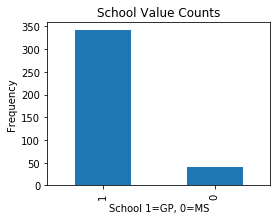

In [29]:
# Visualize distribution of each variable, the same for mat and por students since merged datasets
fig, ax = plt.subplots(1, sharey=True, figsize=(4, 3))
counts = mat_students['school'].value_counts()
print("Value Counts: GP={}, MS={}" .format(counts[1],counts[0]))
mat_students['school'].value_counts().plot(ax=ax, kind='bar', xlabel='School 1=GP, 0=MS', ylabel='Frequency', title='School Value Counts')
plt.show()

In [30]:
school = [1, 0]

# Grouped bar chart of mean grades per school
def grouped_bar(table):
    width = 0.2
    for x in school:
        y1 = table.loc[table['school'] == x]['G1'].mean()
        y2 = table.loc[table['school'] == x]['G2'].mean()
        y3 = table.loc[table['school'] == x]['G3'].mean()
        plt.bar(x-0.2, y1, width, color='blue', edgecolor='black') 
        plt.bar(x, y2, width, color='orange', edgecolor='black') 
        plt.bar(x+0.2, y3, width, color='green', edgecolor='black') 

    plt.xticks(school) 
    plt.xlabel("School") 
    plt.ylabel("Mean Grade")
    title = "Mean Grades by School"
    plt.title("Mean Grades by School")
    plt.legend(["G1", "G2", "G3"], loc='lower center') 
    plt.show() 

MAT STUDENTS


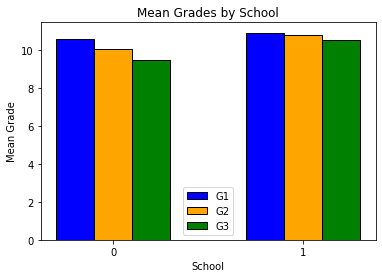

POR STUDENTS


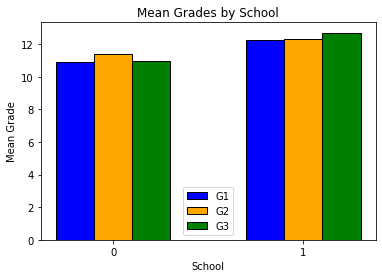

In [31]:
print("MAT STUDENTS")
grouped_bar(mat_students)
print("POR STUDENTS")
grouped_bar(por_students)

Interpret results...

## Significance Testing Using Independent T-Test Comparing Mean Grades Across Schools

In [32]:
grades = ['G1', 'G2', 'G3']

# Independent T-test Comparing Means Grades Across Study Times
def create_ttest_table(table):
    data = []
    for grade in grades:
        x1 = table.loc[table['school'] == 1][grade]
        x2 = table.loc[table['school'] == 0][grade]
        ttests = [stats.ttest_ind(x1,x2, equal_var=False)[1]]
        data.append([x1.mean(), x2.mean(), grade, ttests[0], '*' if ttests[0] < 0.05 else ''])
    return pd.DataFrame(data, columns=['School GP Mean Grade', 'School MS Mean Grade', 'grade', 'p-value', '|< 0.05|'])

In [33]:
create_ttest_table(mat_students)

,School GP Mean Grade,School MS Mean Grade,grade,p-value,|< 0.05|
0,10.897661,10.550,G1,0.550937,
1,10.789474,10.050,G2,0.224425,
2,10.494152,9.475,G3,0.197255,


In [34]:
create_ttest_table(por_students)

,School GP Mean Grade,School MS Mean Grade,grade,p-value,|< 0.05|
0,12.257310,10.875,G1,0.015402,*
1,12.336257,11.400,G2,0.080356,
2,12.698830,10.950,G3,0.025500,*


Interpret results....

## Univariate Analysis Simple Linear Regression
Using school as the independent variable, and G3 as the dependent variable.

In [35]:
x_mat = mat_students['school']
y_mat = mat_students['G3']
X1 = sm.add_constant(x_mat) # adds constant to the model
model_mat = sm.OLS(y_mat, X1).fit()
model_mat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.696
Date:                Tue, 18 Jun 2024   Prob (F-statistic):              0.194
Time:                        18:08:23   Log-Likelihood:                -1130.8
No. Observations:                 382   AIC:                             2266.
Df Residuals:                     380   BIC:                             2274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4750      0.740     12.796      0.000       8.019      10.931
school         1.0192      0.783      1.302      0.194      -0.520       2.558
==============================================================================
Omnibus:                       28.772   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.176
Skew:                          -0.709   Prob(JB):                     6.25e-08
Kurtosis:                       3.272   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$y = 9.48 + 1.02(school)$ .....interpret

In [36]:
x_por = por_students['school']
y_por = por_students['G3']
X1 = sm.add_constant(x_por) # adds constant to the model
model = sm.OLS(y_por, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     13.02
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           0.000349
Time:                        18:08:23   Log-Likelihood:                -947.76
No. Observations:                 382   AIC:                             1900.
Df Residuals:                     380   BIC:                             1907.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9500      0.459     23.880      0.000      10.048      11.852
school         1.7488      0.485      3.609      0.000       0.796       2.702
==============================================================================
Omnibus:                       57.258   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.642
Skew:                          -0.731   Prob(JB):                     2.37e-32
Kurtosis:                       5.648   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$y = 10.95 + 1.75(school)$ .....interpret